In [2]:
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Step 1: Load the GeoDataFrame with polygons and calculate the area of each polygon
votes_gdf = gpd.read_file('fl_2016/fl_2016.shp')

votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR']  # calculate votes for blue per precinct
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB']  # calculate votes for red per precinct

# Step 2: Reproject to a projected CRS
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)  # You can change EPSG code to a suitable one for your area

# Step 3: Calculate the area using the projected GeoDataFrame
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area

# Define the attribute columns to be rasterized
selected_columns = ['blue', 'red']

# Step 4: Define the bounds and raster properties
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Set up the transform for the raster
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Step 5: Rasterize each attribute column separately into bands with fractional values
raster_bands = []
pixel_area = pixel_size ** 2  # Calculate the area of a single pixel

for col in selected_columns:
    # Generate shapes for rasterization, scaling by pixel area
    shapes = (
        (geom, (value / area) * pixel_area) 
        for geom, value, area in zip(votes_gdf_projected.geometry, votes_gdf_projected[col], votes_gdf_projected['area'])
    )
    
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'  # Using float to handle fractional values
    )
    raster_bands.append(raster_band)

# Step 6: Verify the results
total_population = sum(band.sum() for band in raster_bands)
original_population = votes_gdf['blue'].sum() + votes_gdf['red'].sum()

print(f"Total population from raster: {total_population}")
print(f"Original total population: {original_population}")


Total population from raster: 18182874.0
Original total population: 18080140


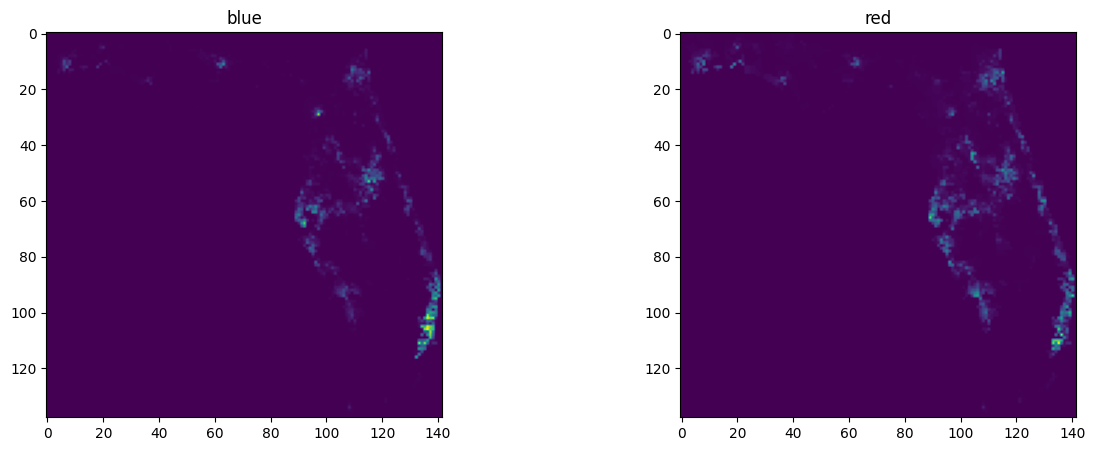

In [3]:
# Visualize one of the raster bands for verification (optional)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(selected_columns), figsize=(15, 5))
for i, band in enumerate(raster_bands):
    axs[i].imshow(band, cmap='viridis')
    axs[i].set_title(f'{selected_columns[i]}')
plt.show()


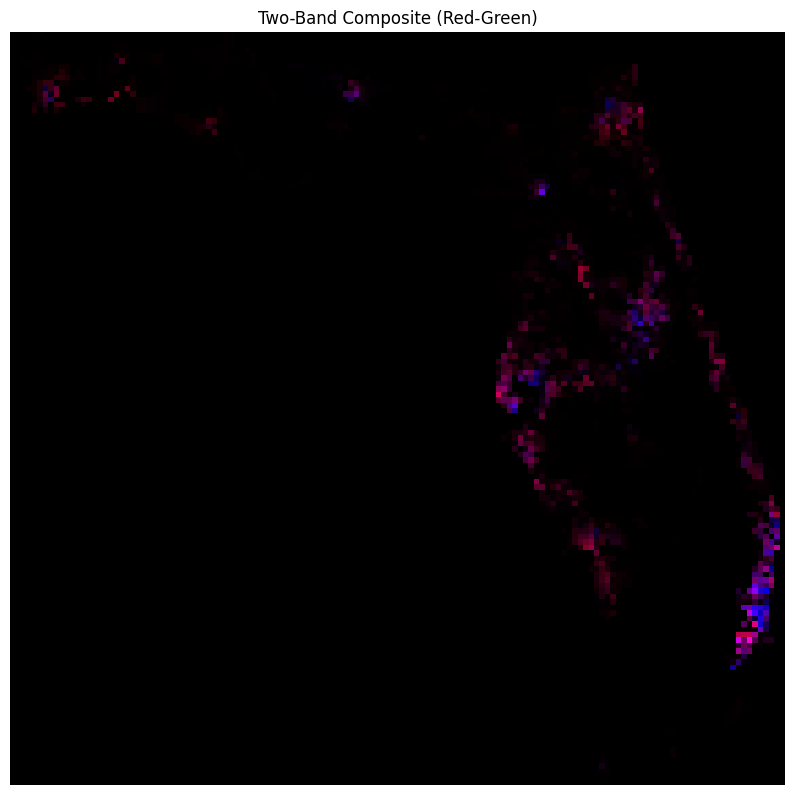

In [4]:
import numpy as np

# Get the two bands
blue_band = raster_bands[0]
red_band = raster_bands[1]

# Normalize bands to [0, 1] for visualization
def normalize(array):
    return (array - array.min()) / (array.max() - array.min())

blue_norm = normalize(blue_band)
red_norm = normalize(red_band)
green_norm = np.zeros_like(red_norm)  # Set green channel to zero

# Stack bands to create an RGB image
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Two-Band Composite (Red-Green)')
plt.axis('off')
plt.show()

## **Sample from district boundaries**

In [5]:
# create a GeoDataFrame with the boundaries of congressional districts
districts_gdf = gpd.read_file('fl_2016_congressional_districts/fl_2016_congressional_districts.shp')

# project into same scale
districts_gdf_projected = districts_gdf.to_crs(epsg=3857)

# assign id to each district
districts_gdf_projected["poly_id"] = np.arange(len(districts_gdf_projected))

# get polygon boundaries
boundary_gdf = districts_gdf_projected.copy()
boundary_gdf['geometry'] = boundary_gdf.geometry.boundary

In [6]:

# Rasterize the boundaries
boundary_shapes = ((geom, 1) for geom in boundary_gdf.geometry)
boundary_mask = rasterize(
    shapes=boundary_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Also rasterize polygon IDs
poly_id_shapes = ((geom, pid) for geom, pid in zip(districts_gdf_projected.geometry, districts_gdf_projected['poly_id']))
poly_id_raster = rasterize(
    shapes=poly_id_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='int32'
)

# mask pixels that have non-zero value and in a border
mask = ((blue_band > 0) | (red_band > 0)) & (boundary_mask > 0)

# get all candidate pixels
candidate_pixels = np.argwhere(mask)

# get pixels that are in the border of two districts
def get_neighbors(r, c, arr):
    """Get the values of the 8-connected neighbors and the pixel itself."""
    rows = [r-1, r-1, r-1, r, r, r+1, r+1, r+1]
    cols = [c-1, c, c+1, c-1, c+1, c-1, c, c+1]
    vals = []
    for rr, cc in zip(rows, cols):
        if 0 <= rr < arr.shape[0] and 0 <= cc < arr.shape[1]:
            vals.append(arr[rr, cc])
    return vals

# Filter candidate pixels to those between exactly two distinct polygons
valid_pixels = []
for (row, col) in candidate_pixels:
    # Get polygon IDs of neighbors
    neighbor_ids = get_neighbors(row, col, poly_id_raster)
    # Include the pixel itself to consider its own polygon ID
    center_id = poly_id_raster[row, col]
    all_ids = neighbor_ids + [center_id]
    
    # Count distinct non-zero IDs
    distinct_ids = set(all_ids) - {0}
    if len(distinct_ids) == 2:
        valid_pixels.append((row, col))

Randomly selected boundary pixel at (row 69, col 103):
  Value in Blue Band: 36.57978057861328
  Value in Red Band: 44.979000091552734


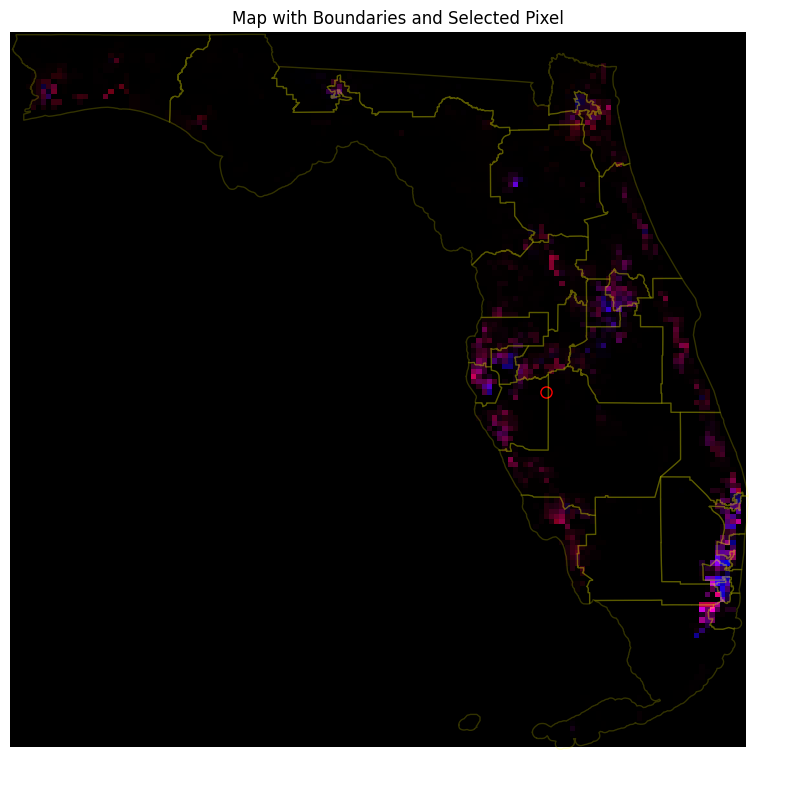

In [20]:
import random

# random sample a pixel and display 
if len(valid_pixels) == 0:
    print("No valid boundary pixels found.")
else:
    random_index = random.randint(0, len(valid_pixels) - 1)
    row, col = valid_pixels[random_index]

    blue_value = blue_band[row, col]
    red_value = red_band[row, col]

    print(f"Randomly selected boundary pixel at (row {row}, col {col}):")
    print(f"  Value in Blue Band: {blue_value}")
    print(f"  Value in Red Band: {red_value}")

    # Plot the RGB image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rgb, origin='upper')

    # Mark the selected pixel
    ax.plot(col, row, 'ro', markersize=8, markerfacecolor='none', markeredgecolor='red')

    # Convert line geometries from projected coords to pixel coords and plot them
    inv_transform = ~transform  # Inverse transform to go from map coords to pixel coords
    for geom in boundary_gdf.geometry:
        # Each geometry is a LineString or MultiLineString
        if geom is None:
            continue
        
        if geom.geom_type == 'MultiLineString':
            lines = geom.geoms
        else:
            lines = [geom]

        for line in lines:
            x_coords, y_coords = line.xy
            # Convert to pixel coordinates
            pixel_coords = [inv_transform * (x, y) for x, y in zip(x_coords, y_coords)]
            # pixel_coords is now a list of (col, row) tuples
            cols, rows = zip(*pixel_coords)
            ax.plot(cols, rows, color='yellow', linewidth=1, alpha=0.2)

    ax.set_title('Map with Boundaries and Selected Pixel')
    ax.axis('off')
    plt.show()

## **Generate random districts**

In [22]:
total_pop = votes_gdf["blue"].sum() + votes_gdf["red"].sum()
total_pop_raster = (raster_bands[0] + raster_bands[1]).sum()
num_districts = 27 # in 2016
target_pop = total_pop_raster / num_districts

print(f"Total population: {total_pop}")
print(f"Total population raster: {total_pop_raster}")
print(f"Target population per district: {target_pop:.2f}")

Total population: 18080140
Total population raster: 18182874.0
Target population per district: 673439.75


In [23]:
# total population per pixel
population = raster_bands[0] + raster_bands[1]

height, width = population.shape

print(height, width)

138 142


In [28]:
raster_bands[0].max()

np.float32(71352.02)

In [29]:
votes_gdf_projected["blue"].max()

np.int64(10184)

**Required packages**

In [98]:
import numpy as np
import geopandas as gpd
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from scipy.ndimage import distance_transform_edt
import random
from matplotlib.colors import ListedColormap

**Loading and Rasterizing Precinct Data**

In [ ]:
# =======================
# Loading data
# =======================

precinct_shapefile = 'fl_2016/fl_2016.shp'
votes_gdf = gpd.read_file(precinct_shapefile)

# calculate votes (blue = democrat, red = republican)
votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR']  # Blue votes
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB']   # Red votes

# Reproject to a Projected CRS
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)

# calculate area to get pop per pixel
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area


# =======================
# Rasterizing
# =======================

# select columns to be rasterized
# (to calculate total votes per pixel)
selected_columns = ['blue', 'red']

# get coordinates
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000  # Adjust pixel size as needed (in meters)
width = int(np.ceil((maxx - minx) / pixel_size))
height = int(np.ceil((maxy - miny) / pixel_size))
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# rasterize attributes
raster_bands = []
for col in selected_columns:
    # Create shapes for rasterization with scaled values
    shapes = (
        (geom, value)
        for geom, value in zip(votes_gdf_projected.geometry, votes_gdf_projected[col])
    )
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'
    )
    raster_bands.append(raster_band)

blue_band, red_band = raster_bands

# total votes/population per pixel
population = blue_band + red_band 

# =======================
# Florida mask
# this part ignores pixels that are not within Florida
# =======================

# get the boundary of Florida state
florida_union = votes_gdf_projected.union_all()

# Ensure the union is a Polygon or MultiPolygon
if not isinstance(florida_union, (Polygon, MultiPolygon)):
    raise ValueError("Unexpected geometry type for unary_union. Expected Polygon or MultiPolygon.")

# Rasterize the Florida boundary to create a mask
florida_mask = rasterize(
    [(florida_union, 1)], # 1 is pixel is inside, 0 otherwise
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Apply the Florida mask to the population array
# Pixels outside Florida will have population = 0
population_masked = population * florida_mask

**Voronoi Districts Function**

In [ ]:
def generate_voronoi_districts(population_masked, num_districts=27, random_seed=None):
    """
    Generates Voronoi-based districts within Florida based on a population raster.

    Parameters:
        population_masked (np.ndarray): 2D array representing population per pixel within Florida.
        num_districts (int): Number of districts to generate. Default is 27.
        tolerance (float): Population tolerance (unused in Voronoi, but kept for reference). Default is 50000.
        random_seed (int, optional): Seed for random number generator for reproducibility.

    Returns:
        district_map (np.ndarray): 2D array with district IDs assigned to each pixel. Pixels outside Florida are -1.
        seed_coords (np.ndarray): Array of shape (num_districts, 2) with seed pixel coordinates (row, column).
        target_pop (float): Target population per district.
    """
    # specify seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Calculate total and target population
    total_pop = population_masked.sum()
    target_pop = total_pop / num_districts
    # print("Total population within Florida:", total_pop)
    # print("Target population per district:", target_pop)

    # =======================
    # Voronoi Tesselation
    # =======================

    # get pixels within Florida
    valid_pixels = np.argwhere(population_masked > 0)
    if len(valid_pixels) < num_districts:
        raise ValueError("Not enough valid pixels to assign to districts.")

    # randomly sample 27 pixels
    seed_indices = random.sample(range(valid_pixels.shape[0]), num_districts)
    seed_coords = valid_pixels[seed_indices]

    # create an empty district map
    # initialize with -1 for ocean pixels (outside Florida)
    height, width = population_masked.shape
    district_map = -1 * np.ones((height, width), dtype=int)

    # assign each sampled pixel to a district
    for d_id, (r, c) in enumerate(seed_coords):
        district_map[r, c] = d_id

    # compute Voronoi Tessellation
    # Create a boolean array where seed pixels are True
    seed_mask = np.zeros((height, width), dtype=bool)
    seed_mask[seed_coords[:, 0], seed_coords[:, 1]] = True

    # find the nearest pixel to each sampled pixel
    distance, indices = distance_transform_edt(~seed_mask, return_indices=True)

    # assign each pixel to the nearest seed's district ID
    nearest_row = indices[0]
    nearest_col = indices[1]
    nearest_district = district_map[nearest_row, nearest_col]

    # update the district map for all valid pixels
    district_map[population_masked > 0] = nearest_district[population_masked > 0]

    # =======================
    # Calculate Population and Vote Percentages
    # =======================

    # Initialize lists to store data for each district
    district_ids = range(num_districts)
    total_population = []
    total_blue = []
    total_red = []
    percentage_blue = []
    percentage_red = []

    # create data frame with population and votes per district
    # ---------------------------------------

    for d_id in district_ids:
        # Create a mask for the current district
        mask = (district_map == d_id)
        
        # Calculate total population for the district
        pop = population_masked[mask].sum()
        total_population.append(pop)
        
        # Calculate total blue and red votes for the district
        blue = blue_band[mask].sum()
        red = red_band[mask].sum()
        total_blue.append(blue)
        total_red.append(red)
        
        # Calculate percentage of blue and red votes
        if pop > 0:
            percentage_blue.append((blue / pop) * 100.0)
            percentage_red.append((red / pop) * 100.0)
        else:
            percentage_blue.append(0)
            percentage_red.append(0)
    
    # ---------------------------------------

    data = {
        'District': district_ids,
        'Total Population': total_population,
        'Blue Votes': total_blue,
        'Red Votes': total_red,
        'Percentage Blue': percentage_blue,
        'Percentage Red': percentage_red
    }

    df = pd.DataFrame(data)

    # =======================
    # Plots:
    #  =======================

    #  Voronoi Districts
    # ------------------------
    district_colors = plt.get_cmap('tab20', num_districts).colors[:num_districts]
    colors = list(district_colors) + [(0, 0, 0, 1)]  # Adding black for ocean
    custom_cmap = ListedColormap(colors)

    # Step 2: Adjust district_map to Shift -1 to the Last Index (for black color)
    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts  # Assign -1 to black

    # Step 3: Plot the District Map
    plt.figure(figsize=(6, 6))
    im = plt.imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper',
        extent=(minx, maxx, miny, maxy)
    )
    # cbar = plt.colorbar(im, ticks=range(num_districts + 1))
    # cbar.ax.set_yticklabels([str(i) for i in range(num_districts)] + ['Outside Florida'])
    plt.title('27 Districts Generated via Voronoi Tessellation (Black = Outside Florida)')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.show()

    # Population and Votes per District
    # ------------------------

    fig, axes = plt.subplots(1, 2, figsize=(28, 7))  # 1 row, 2 columns

    # Plot 1: Total Population per District
    axes[0].bar(df['District'], df['Total Population'], color='lightgreen')
    axes[0].set_xlabel('District ID', fontsize=14)
    axes[0].set_ylabel('Total Population', fontsize=14)
    axes[0].set_title('Total Population per District', fontsize=16)
    axes[0].set_xticks(df['District'])
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Percentage of Blue vs Red Votes per District
    width = 0.6  # Width of the bars

    # Plot Blue Votes
    axes[1].bar(df['District'], df['Percentage Blue'], width, label='Blue', color='skyblue')

    # Plot Red Votes on top of Blue Votes
    axes[1].bar(df['District'], df['Percentage Red'], width, bottom=df['Percentage Blue'], label='Red', color='pink')

    axes[1].set_xlabel('District ID', fontsize=14)
    axes[1].set_ylabel('Percentage of Votes (%)', fontsize=14)
    axes[1].set_title('Percentage of Blue vs Red Votes per District', fontsize=16)
    axes[1].set_xticks(df['District'])
    axes[1].legend(fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


    # Pixels outside Florida remain -1 (black)
    return district_map, seed_coords, target_pop


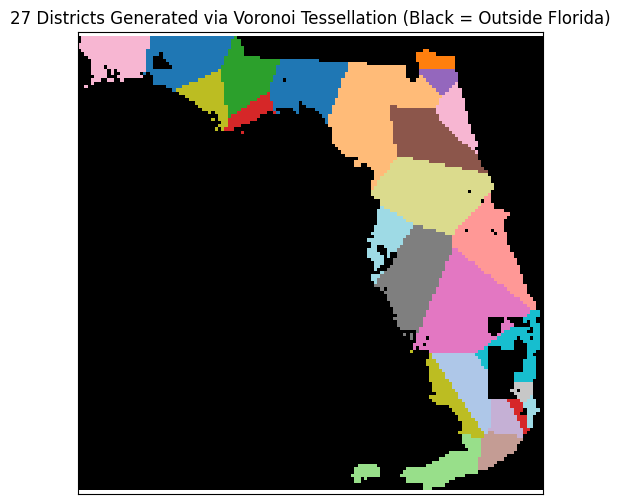

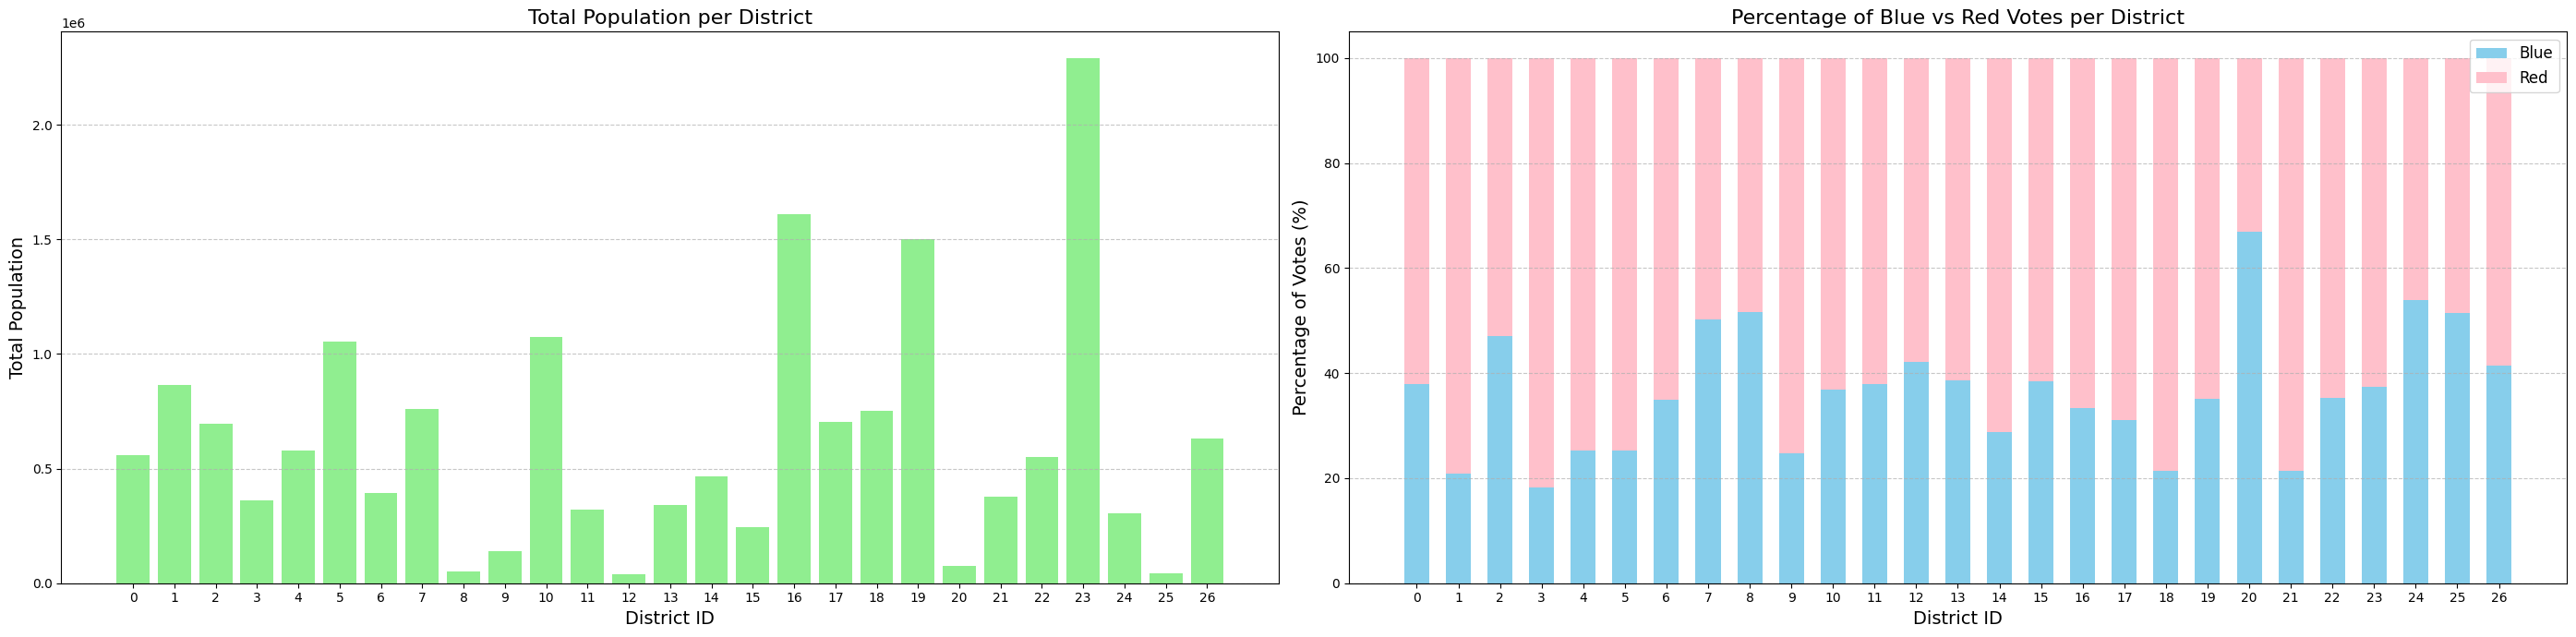

In [129]:
district_map, seed_coords, target_pop = generate_voronoi_districts(population_masked, 27)